In [104]:
import requests as rq
import json
import pandas as pd
pd.set_option('display.precision', 4,
              'display.colheader_justify', 'center')
import numpy as np
import warnings
import pytz
import datetime
import time
from IPython.display import clear_output

from sqlalchemy import create_engine
import plotly.express as px

In [2]:
# Get demo API key
def get_demo_key():
    f = open("/home/vikas/Documents/CG_demo_key.json")
    key_dict = json.load(f)
    return key_dict["key"] 

In [3]:
use_demo = {
           "accept": "application/json",
           "x-cg-demo-api-key" : get_demo_key() 
}

In [4]:
# Get pro API key
def get_pro_key():
    f = open("/home/vikas/Documents/CG_pro_key.json")
    key_dict = json.load(f)
    return key_dict["key"] 

## Get list of exchanges

In [5]:
PUB_URL = "https://api.coingecko.com/api/v3"
PRO_URL = "https://pro-api.coingecko.com/api/v3"

In [6]:
def get_response(endpoint, headers, params, URL):
    url = "".join((URL, endpoint))
    response = rq.get(url, headers = headers, params = params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch data, check status code {response.status_code}")    

In [7]:
# Valid values for results per page is between 1-250
exchange_params = {
            "per_page": 250,
            "page": 1
}

In [8]:
exchange_list_response = get_response("/exchanges", use_demo, exchange_params, PUB_URL)

#### List exchanges by trading volume

In [9]:
df_ex = pd.DataFrame(exchange_list_response)
df_ex_subset = df_ex[["id", "name", "country", "trade_volume_24h_btc"]]
df_ex_subset = df_ex_subset.sort_values(by = ["trade_volume_24h_btc"], ascending = False)

In [10]:
df_ex_subset["country"].unique()

array(['Cayman Islands', 'British Virgin Islands', 'Malta', 'Seychelles',
       'Lithuania', 'United States', 'United Arab Emirates', 'Gibraltar',
       'Singapore', 'Australia', None, 'South Korea', 'Marshall Islands',
       'Bahamas', 'Spain', 'Belize', 'Luxembourg', 'Samoa', 'Netherlands',
       'Costa Rica', 'Turkey', 'Saint Vincent and the Grenadines',
       'Argentina', 'Japan', 'Vanuatu', 'Bermuda', 'United Kingdom',
       'Hong Kong', 'Thailand', 'India', 'Taiwan', 'Brazil', 'Panama',
       'Indonesia', 'Switzerland', 'Unknown or Invalid Region',
       'Philippines', 'South Africa', 'Estonia', 'Georgia', 'Jamaica',
       'Slovenia'], dtype=object)

In [11]:
#df_ex_subset[(df_ex_subset["country"] == "United States")]

## Get exchange tickers

In [12]:
def get_trade_exchange(id, base_curr, target_curr):
    
    exchange_ticker_response = get_response(f"/exchanges/{id}/tickers",
                                            use_demo,
                                            {},
                                            PUB_URL)
    
    found_match = ""
    
    for ticker in exchange_ticker_response["tickers"]:
        if ticker["base"] == base_curr and ticker["target"] == target_curr:
            found_match = ticker
            break
            
    if found_match == "":
        warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
    
    return found_match

In [13]:
test_data = get_trade_exchange("gdax", "ETH", "EUR")
test_data

{'base': 'ETH',
 'target': 'EUR',
 'market': {'name': 'Coinbase Exchange',
  'identifier': 'gdax',
  'has_trading_incentive': False},
 'last': 2068.15,
 'volume': 2886.05801067,
 'converted_last': {'btc': 0.04220778, 'eth': 1.002308, 'usd': 2293.61},
 'converted_volume': {'btc': 121.814, 'eth': 2893, 'usd': 6619497},
 'trust_score': 'green',
 'bid_ask_spread_percentage': 0.028046,
 'timestamp': '2024-09-07T20:09:43+00:00',
 'last_traded_at': '2024-09-07T20:09:43+00:00',
 'last_fetch_at': '2024-09-07T20:09:43+00:00',
 'is_anomaly': False,
 'is_stale': False,
 'trade_url': 'https://www.coinbase.com/advanced-trade/spot/ETH-EUR',
 'token_info_url': None,
 'coin_id': 'ethereum'}

## Convert to local timezone

In [14]:
def convert_to_local_tz(old_ts):
    
    new_tz = pytz.timezone("Europe/Amsterdam")
    old_tz = pytz.timezone("UTC")
    
    format = "%Y-%m-%dT%H:%M:%S+00:00"
    datetime_obj = datetime.datetime.strptime(old_ts, format)
    
    localized_ts = old_tz.localize(datetime_obj)
    new_ts = localized_ts.astimezone(new_tz)
    
    return new_ts   

## Collect data for multiple exchanges based on country

In [15]:
def get_trade_exchange_per_country(country,
                                   base_curr,
                                   target_curr):
    
    df_all = df_ex_subset[(df_ex_subset["country"] == country)]    
    
    exchanges_list = df_all["id"]
    ex_all = []    
       
    for exchange_id in exchanges_list:
        found_match = get_trade_exchange(exchange_id, base_curr, target_curr)
        if found_match == "":
            continue
        else:
            temp_dict = dict(
                             exchange = exchange_id,
                             last_price = found_match["last"],
                             last_vol   = found_match["volume"],
                             spread     = found_match["bid_ask_spread_percentage"],
                             trade_time = convert_to_local_tz(found_match["last_traded_at"])
                             )
            ex_all.append(temp_dict)
            
    return pd.DataFrame(ex_all)   

In [16]:
df_ex_all = get_trade_exchange_per_country("United States", "ETH", "EUR")
df_ex_all

/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in tapbit
  warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in kraken
  warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in itbit
  warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in binance_us
  warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in metalx
  warnings.warn(f"No data found for {base_curr}-{target_curr} pair in {id}")
/tmp/ipykernel_19500/3109473306.py:16: UserWarning: No data found for ETH-EUR pair in oku-trade-taiko
  warnings.warn(f"No data found for {base_cur

,exchange,last_price,last_vol,spread,trade_time
0,gdax,2068.15,2886.0580,0.0280,2024-09-07 22:09:43+02:00
1,gemini,2070.89,13.0046,0.0227,2024-09-07 22:03:15+02:00


## Get exchange rates

In [17]:
def get_exchange_rate(base_curr):
    
    # This returns current BTC to base_curr exchange rate    
    exchange_rate_response = get_response(f"/exchange_rates",
                                          use_demo,
                                          {},
                                          PUB_URL)
    rate = ""
    try:
        rate = exchange_rate_response["rates"][base_curr.lower()]["value"]
    except KeyError as ke:
        print("Currency not found in the exchange rate API response:", ke)
        
    return rate    

In [18]:
get_exchange_rate("ETH")

23.75

## Get historical volume data

In [19]:
def get_vol_exchange(id, days, base_curr):
    
    vol_params = {"days": days}
    
    exchange_vol_response = get_response(f"/exchanges/{id}/volume_chart",
                                         use_demo,
                                         vol_params,
                                         PUB_URL)
    
    time, volume = [], []
    
    # Get exchange rate when base_curr is not BTC
    ex_rate = 1.0
    if base_curr != "BTC":
        ex_rate = get_exchange_rate(base_curr)
        
        # Give a warning when exchange rate is not found
        if ex_rate == "":
            print(f"Unable to find exchange rate for {base_curr}, vol will be reported in BTC")
            ex_rate = 1.0
    
    for i in range(len(exchange_vol_response)):
        # Convert to seconds
        s = exchange_vol_response[i][0] / 1000
        time.append(datetime.datetime.fromtimestamp(s).strftime('%Y-%m-%d'))
        
        # Default unit for volume is BTC
        volume.append(float(exchange_vol_response[i][1]) * ex_rate)
                      
    df_vol = pd.DataFrame(list(zip(time, volume)), columns = ["date", "volume"])
    
    # Calculate SMA for a specific window
    df_vol["volume_SMA"] = df_vol["volume"].rolling(7).mean()
    
    return df_vol.sort_values(by = ["date"], ascending = False).reset_index(drop = True)

In [20]:
#get_vol_exchange("kraken", 30, "BTC")

## Collect and display aggregate per exchange

In [21]:
def display_agg_per_exchange(df_ex_all, base_curr):
    
    # Group data and calculate statistics per exchange    
    df_agg = (
        df_ex_all.groupby("exchange").agg
        (        
            trade_time_min = ("trade_time", 'min'),
            trade_time_latest = ("trade_time", 'max'),
            last_price_mean = ("last_price", 'mean'),
            last_vol_mean = ("last_vol", 'mean'),
            spread_mean = ("spread", 'mean'),
            num_trades = ("last_price", 'count')
        )
    )
    
    # Get time interval over which statistics have been calculated    
    df_agg["trade_time_duration"] = df_agg["trade_time_latest"] - df_agg["trade_time_min"]
    
    # Reset columns so that we can access exchanges below
    df_agg = df_agg.reset_index()
    
    # Calculate % of total volume for all exchanges
    last_vol_pert = []
    for i, row in df_agg.iterrows():
        try:
            df_vol = get_vol_exchange(row["exchange"], 30, base_curr)
            current_vol = df_vol["volume_SMA"][0]
            vol_pert = (row["last_vol_mean"] / current_vol) * 100
            last_vol_pert.append(vol_pert)
        except:
            last_vol_pert.append("")
            continue
            
    # Add % of total volume column
    df_agg["last_vol_pert"] = last_vol_pert
    
    # Remove redundant column
    df_agg = df_agg.drop(columns = ["trade_time_min"])
    
    # Round all float values
    # (seems to be overwritten by style below)
    df_agg = df_agg.round({"last_price_mean": 2,
                           "last_vol_mean": 2,
                           "spread_mean": 2
                          })
    
    display(df_agg.style.apply(highlight_max_min,
                               color = 'green',
                               subset = "last_price_mean")
           )
    
    return None

In [22]:
def highlight_max_min(x, color):
    
    return np.where((x == np.nanmax(x.to_numpy())) |
                    (x == np.nanmin(x.to_numpy())),
                    f"color: {color};",
                    None)

In [23]:
#display_agg_per_exchange(df_ex_all)

## Run bot

In [24]:
def run_bot(country,
            base_curr,
            target_curr):
    
    df_ex_all = get_trade_exchange_per_country(country, base_curr, target_curr)
    
    # Collect data every minute    
    while True:
        time.sleep(60)
        df_new = get_trade_exchange_per_country(country, base_curr, target_curr)
        
        # Merge to existing DataFrame
        df_ex_all = pd.concat([df_ex_all, df_new])
        
        # Remove duplicate rows based on all columns
        df_ex_all = df_ex_all.drop_duplicates()
        
        # Clear previous display once new one is available
        clear_output(wait = True)
        display_agg_per_exchange(df_ex_all, base_curr)        
        
    return None        

In [25]:
#run_bot("United States", "ETH", "USDT")

## Write to database

In [96]:
def create_db(df_ex_all, engine):
    
    for ex in df_ex_all["exchange"]:
        df_ex = df_ex_all[df_ex_all["exchange"] == ex]
        
        # Write to a new separate table in sqlite database
        df_ex.to_sql(name = ex, con = engine, if_exists = 'replace')
        
    return None        

In [100]:
def append_to_db(df_ex_all, engine):
    
    for ex in df_ex_all["exchange"]:        
        try:            
            df_ex = df_ex_all[df_ex_all["exchange"] == ex]

            # Remove timezone information for easier comparison later
            new_ts = df_ex["trade_time"][0]
            new_ts = new_ts.replace(tzinfo = None)

            # Read existing table
            df_table = pd.read_sql(f'SELECT * FROM {ex}', engine)

            # Read last row (should be latest)
            existing_ts = datetime.datetime.strptime(df_table["trade_time"].iloc[-1], 
                                                     "%Y-%m-%d %H:%M:%S.%f")

            if existing_ts == new_ts:
                print("Last trade already exists!")
            else:
                df_ex.to_sql(name = ex, con = engine, if_exists = 'append')
        except:
            warnings.warn(f'Unable to append data for {ex}')
            continue
            
    return None       
        

## Plot from database

In [133]:
def plot_ex_from_db(ex, engine, base_curr, target_curr):
    
    # Read existing table
    df_table = pd.read_sql(f'SELECT * FROM {ex}', engine)
    
    fig = px.line(df_table,
                  x = df_table.trade_time,
                  y = df_table.last_price,
                  title = f"{base_curr}-{target_curr} price data for {ex}",
                  markers = True
                  )
    
    return fig    

## Run bot database

In [134]:
def run_bot_db(country,
               ex,
               base_curr,
               target_curr):
    
    engine = create_engine(f'sqlite:///{country}_{base_curr}_{target_curr}',
                           echo = False)
    
    df_ex_all = get_trade_exchange_per_country(country, base_curr, target_curr)
    
    try:
        create_db(df_ex_all, engine)
    except:
        warnings.warn(f"Unable to create a new sqlite database!")        
    
    # Collect data every minute    
    while True:
        time.sleep(60)
        df_new = get_trade_exchange_per_country(country, base_curr, target_curr)
        
        # Write new trade data to existing sqlite database        
        append_to_db(df_new, engine)
        
        # Clear previous display once new one is available
        clear_output(wait = True)
        
        # Plot from database
        fig = plot_ex_from_db(ex, engine, base_curr, target_curr)
        fig.show()        
        
    return None        

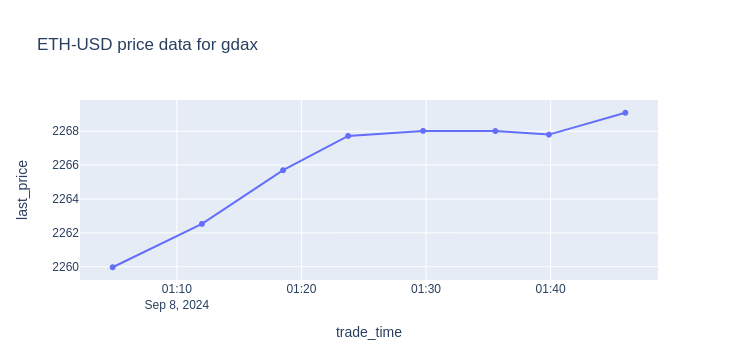

In [ ]:
run_bot_db("United States", "gdax", "ETH", "USD")

## Query from database

In [121]:
# engine = create_engine(f'sqlite:///United States_ETH_USD',
#                        echo = False)
# ex = "gdax"

In [122]:
# df_table = pd.read_sql(f'SELECT * FROM {ex}', engine)
# df_table

,index,exchange,last_price,last_vol,spread,trade_time
0,0,gdax,2265.70,49485.9696,0.0163,2024-09-08 00:40:52.000000
1,0,gdax,2265.84,49578.4720,0.0197,2024-09-08 00:48:53.000000
2,0,gdax,2264.70,49625.9454,0.0110,2024-09-08 00:52:49.000000
